# Homework 6: Exploring precision and recall

### 1. Data preprocessing

In [1]:
import numpy as np
import pandas as pd

In [17]:
# Read data sets
products = pd.read_csv('./amazon_baby.csv')
#important_words = pd.read_json('./important_words.json')

Perform text cleaning

In [94]:
# Clean the raw data
products = products.fillna({'review': ''}) # fill in 'N/A' in the review column

In [95]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)

Extract Sentiments

In [96]:
products = products[products['rating'] != 3] # Ignore all reviews with rating = 3, since they tend to have a neutral sentimen

In [97]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

Split into training and test sets

In [98]:
import json
with open ('module-9-assignment-train-idx.json') as f:
    train_idx = json.load(f)
with open ('module-9-assignment-test-idx.json') as f:
    test_idx = json.load(f) 

In [99]:
train_data = products.iloc[train_idx]
test_data = products.iloc[test_idx]

In [100]:
print train_data.shape
print test_data.shape

(133416, 5)
(33336, 5)


Build the word count vector for each review (bag-of-words)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

### 2. Train a sentiment classifier with logistic regression

In [27]:
from sklearn import linear_model

In [28]:
model = linear_model.LogisticRegression()

In [29]:
model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Model Evaluation

Accuracy

In [31]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true = test_data['sentiment'], y_pred = model.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932205423566


Baseline: Majority class prediction  
Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier is simply the fraction of positive reviews in the test set:

In [33]:
baseline = len(test_data[test_data['sentiment'] == 1]) / float(len(test_data))
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


#### Confusion Matrix

In [35]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true = test_data['sentiment'],
                        y_pred = model.predict(test_matrix),
                        labels = model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   807
      1       |        1        | 27288


Computing the cost of mistakes

In [36]:
100 * 1453 + 1 * 807

146107

### 3. Precision and Recall

#### Precision

[precision] = [# positive data points with positive predictions] / [# all data points with positive predictions]  
            = [# true positives] / ([# true positives]+[# false positives])

In [41]:
from sklearn.metrics import precision_score
precision = precision_score(y_true = test_data['sentiment'], 
                            y_pred = model.predict(test_matrix))
print "Precision on test data: %s" % round(precision, 2)
print "Percentage of false positives on test data: %s" % round((1 - precision), 2)

Precision on test data: 0.95
Percentage of false positives on test data: 0.05


#### Recall

[recall] = [# positive data points with positive predicitions] / [# all positive data points]  
         = [# true positives] / ([# true positives]+[# false negatives])

In [137]:
from sklearn.metrics import recall_score
recall = recall_score(y_true = test_data['sentiment'],
                      y_pred = model.predict(test_matrix))
print "Recall on test data: %s" % round(recall, 2)
print "Percentage of incorrect predictions of positives on test data: %s" % round((1 - recall), 2)

Recall on test data: 0.97
Percentage of incorrect predictions of positives on test data: 0.03


#### Precision-recall tradeoff

A different threshold value will make class predictions.  
Explore a range of threshold values and plot the associated precision-recall curve.

Varying the threshold:

probabilities: an SArray of probability values  
threshold: a float between 0 and 1  
return a array of sentiments

In [139]:
def apply_threshold(probabilities, threshold):
    result = [-1 if elm < threshold else +1 for elm in probabilities] # +1 if >= threshold and -1 otherwise.
    return result

In [140]:
probabilities = model.predict_proba(test_matrix)[:,1]

Exploring the associated precision and recall as the threshold varies:

In [141]:
print 'Threshold == 0.5'
predic_0_5 = apply_threshold(probabilities, 0.5)
print 'Print the number of positive predicted reviews: %s ' % sum([1 if elm == 1 else 0 for elm in predic_0_5])

precision_0_5 = precision_score(y_true = test_data['sentiment'], y_pred = predic_0_5)
print "Precision on test data: %s" % round(precision_0_5, 2)

recall_0_5 = recall_score(y_true = test_data['sentiment'], y_pred = predic_0_5)
print "Recall on test data: %s" % round(recall_0_5, 2)
print '_______________________________________________________________'

print 'Threshold == 0.9'
predic_0_9 = apply_threshold(probabilities, 0.9)
print 'Print the number of positive predicted reviews: %d ' % sum([1 if elm == 1 else 0 for elm in predic_0_9])
precision_0_9 = precision_score(y_true = test_data['sentiment'], y_pred = predic_0_9)
print "Precision on test data: %s" % round(precision_0_9, 2)

recall_0_9 = recall_score(y_true = test_data['sentiment'], y_pred = predic_0_9)
print "Recall on test data: %s" % round(recall_0_9, 2)

Threshold == 0.5
Print the number of positive predicted reviews: 28741 
Precision on test data: 0.95
Recall on test data: 0.97
_______________________________________________________________
Threshold == 0.9
Print the number of positive predicted reviews: 25065 
Precision on test data: 0.98
Recall on test data: 0.88


Precision-recall curve:

In [142]:
threshold_values = np.linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

For each of the values of threshold, we first obtain class predictions using that threshold and then compute the precision and recall scores. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

In [143]:
precision_all = []
recall_all = []

probabilities = model.predict_proba(test_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true = test_data['sentiment'], y_pred = predictions)
    recall = recall_score(y_true = test_data['sentiment'], y_pred = predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

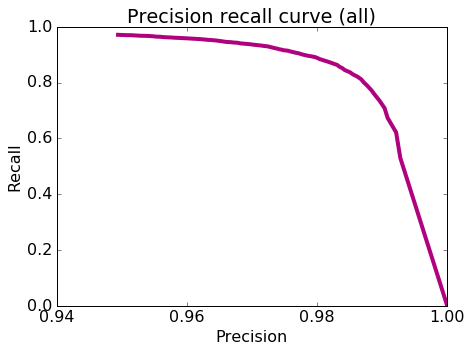

In [145]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [146]:
threshold_values[precision_all >= 0.965].min()

/Users/shute/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  if __name__ == '__main__':


0.50505050505050508

In [83]:
probabilities = model.predict_proba(test_matrix)[:,1]
print 'Threshold == 0.98'
predic_0_98 = apply_threshold(probabilities, 0.98)

Threshold == 0.98


Confusion matrix:

In [87]:
cmat = confusion_matrix(y_true = test_data['sentiment'],
                        y_pred = predic_0_98,
                        labels = model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5048
     -1       |        1        |   193
      1       |       -1        |  8242
      1       |        1        | 19853


Evaluating specific search terms:  
Precision-Recall on all baby related items.

In [153]:
baby_reviews = test_data[test_data['name'].apply(lambda x: type(x) is str and 'baby' in x.lower())]

Now, let's predict the probability of classifying these reviews as positive

In [154]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

Plot the precision-recall curve:

In [155]:
threshold_values = np.linspace(0.5, 1, num = 100)

In [156]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true = baby_reviews['sentiment'], y_pred = predictions)
    recall = recall_score(y_true = baby_reviews['sentiment'], y_pred = predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

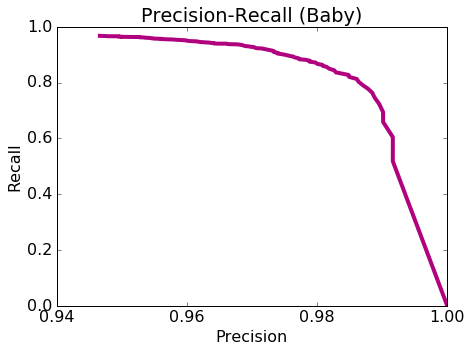

In [157]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")

In [158]:
threshold_values[precision_all >= 0.965].min()

/Users/shute/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  if __name__ == '__main__':


0.50505050505050508